In [1]:
#imports
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import librosa

In [2]:
#load files
files_tr = ['5E63D4B9', '5E63DB05', '5E63D915', '5E63D953', '5E63D899',
             '5E63D47B', '5E63D725', '5E63DA0D', '5E63D9CF', '5E63DA89',
             '5E63D5B1', '5E63DA4B', '5E63D345', '5E63D7DF', '5E63D43D',
             '5E63D6A9', '5E63DB43', '5E63DBFD', '5E63D3FF', '5E63D6E7',
             '5E63D307', '5E63D535', '5E63D7A1', '5E63D3C1', '5E63DAC7',
             '5E63D4F7', '5E63DBBF', '5E63D62D', '5E63D763', '5E63D573']

files_te = ['5E63D383', '5E63D66B', '5E63D5EF']

audio = np.empty((len(files_tr), 2880000))
annotations = []

# change the file structure if necessary
for i, filename in enumerate(files_tr):
    audio[i] = librosa.load('data/audio/{}.WAV'.format(filename), 48000)[0]
    with open('data/annotations/{}.txt'.format(filename)) as file:
        a = []
        for line in file:
            a += [[int(x) for x in line.split()]]
        annotations += [a]

<IPython.core.display.Javascript object>


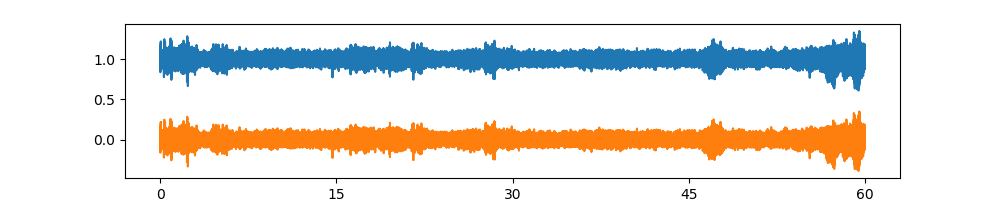

[Text(0, 0, '0'),
 Text(0, 0, '15'),
 Text(0, 0, '30'),
 Text(0, 0, '45'),
 Text(0, 0, '60')]

In [64]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(1.0 + audio[0])
ax.plot(audio[0])
ax.set_xticks(np.linspace(0, 60 * 48000, 5))
ax.set_xticklabels(np.linspace(0, 60, 5, dtype=int))

In [57]:
audio[0].shape

(2880000,)

In [55]:
annotations[0]

[[0, 1648],
 [5017, 6106],
 [8528, 9976],
 [17358, 18763],
 [21773, 23335],
 [36321, 38027],
 [40635, 42413],
 [46054, 47430],
 [48161, 52475]]

In [3]:
# add positive examples of birdsong to pos, background noise/other to neg
sample_len = 1000
pos = []
neg = []
for faudio, fanno in zip(audio, annotations):
    start = 0
    for a in fanno:
        for i in range(a[0] + 100, a[1] - sample_len - 100, sample_len):
            pos += [faudio[i * 48:(i + sample_len) * 48]]
        for i in range(start + 100, a[0] - sample_len - 100, sample_len):
            neg += [faudio[i * 48:(i + sample_len) * 48]]
        start = a[1]
    
pos = np.array(pos)
neg = np.array(neg)

In [4]:
# stack into feature array X and label array y
X = np.vstack([pos, neg])
y = np.hstack([np.ones(pos.shape[0], dtype=bool), np.zeros(neg.shape[0], dtype=bool)])

In [65]:
X.shape

(1402, 48000)

In [5]:
# compute MFCCs for each sample
n_mfcc = 13
X_mfcc = np.empty((X.shape[0], 2 * n_mfcc))
for i, x in enumerate(X):
    mfcc = librosa.feature.mfcc(x, n_mfcc=n_mfcc)
    X_mfcc[i] = np.hstack([mfcc.mean(axis=1), mfcc.std(axis=1)])

In [6]:
X_zcr = np.empty((X.shape[0], 2))
for i, x in enumerate(X):
    zcr = librosa.feature.zero_crossing_rate(x)
    X_zcr[i] = [zcr.mean(), zcr.std()]

In [7]:
X_sc = np.empty((X.shape[0], 2))
for i, x in enumerate(X):
    sc = librosa.feature.spectral_centroid(x)
    X_sc[i] = [sc.mean(), sc.std()]

In [8]:
X_feat = np.hstack([X_mfcc, X_zcr, X_sc])

In [72]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

skb = SelectKBest(mutual_info_classif, k=10).fit(X_feat, y)
idx = skb.scores_.argsort()[:10]

In [73]:
idx.sort()
idx

array([ 3,  4,  5,  8,  9, 10, 13, 15, 16, 17])

<IPython.core.display.Javascript object>


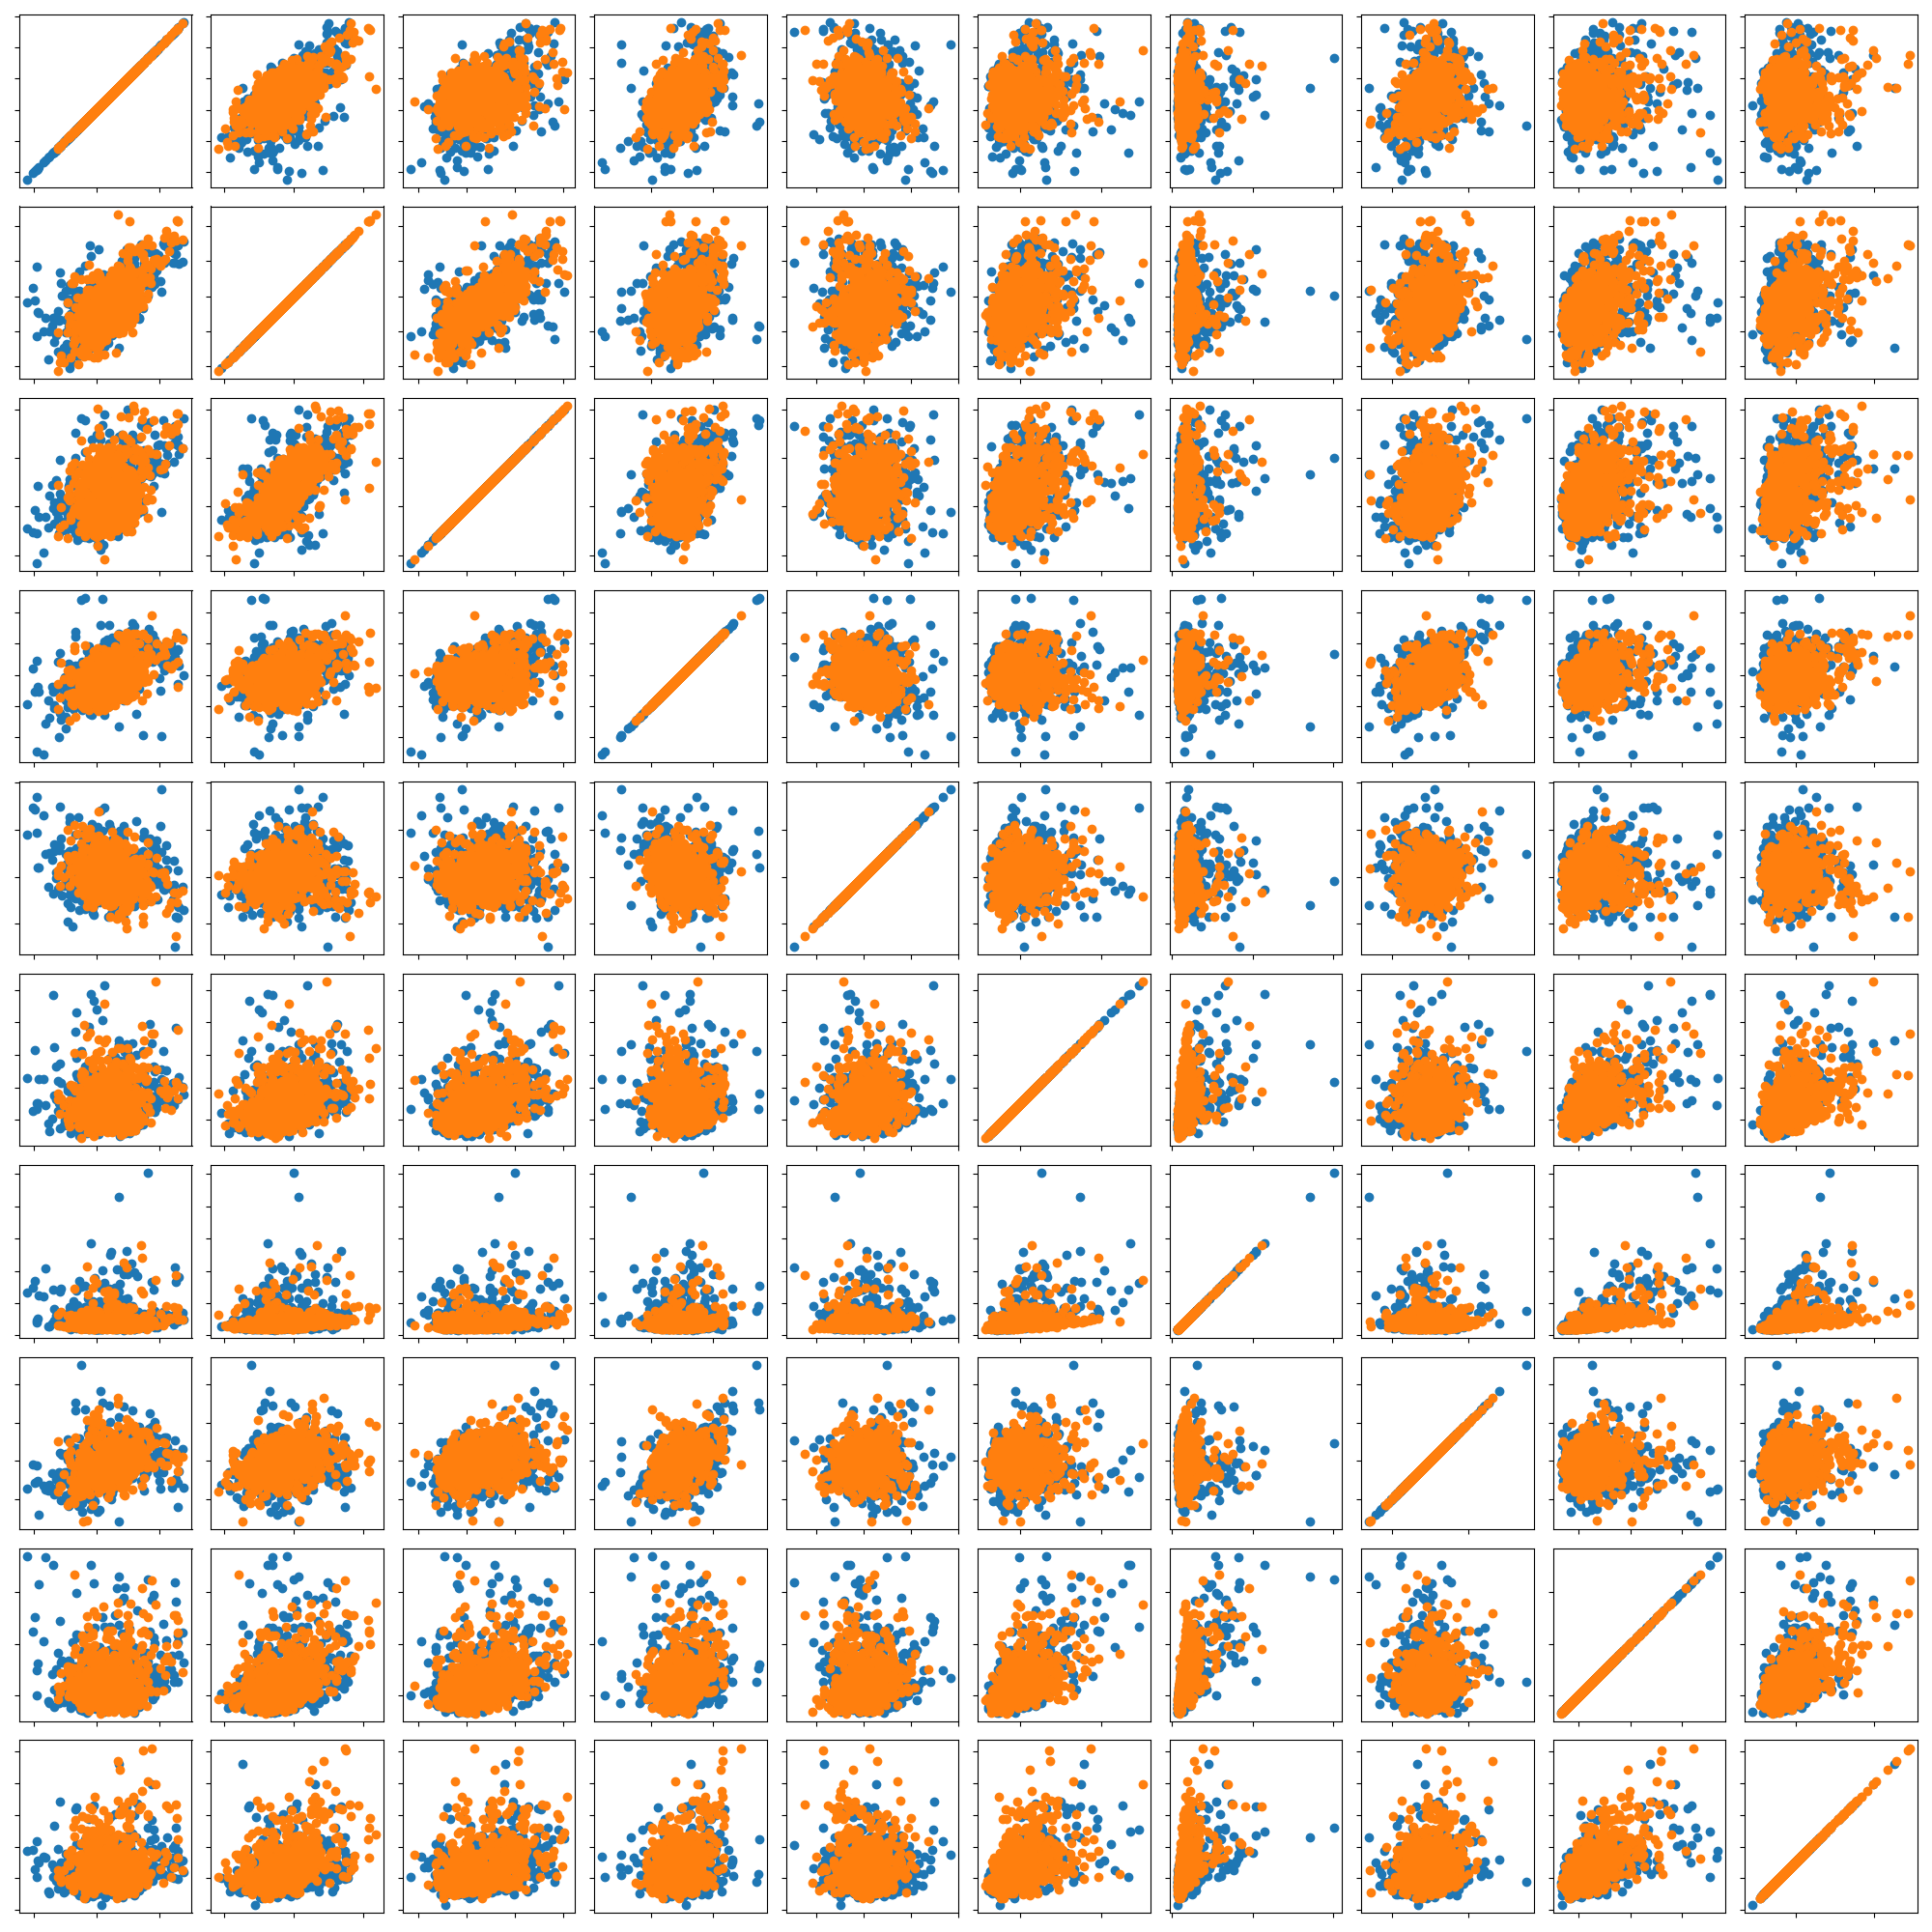

In [54]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for j in range(10):
        axes[i, j].plot(X_feat[y == 0, idx[j]], X_feat[y == 0, idx[i]], marker='o', linestyle='')
        axes[i, j].plot(X_feat[y == 1, idx[j]], X_feat[y == 1, idx[i]], marker='o', linestyle='')
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
fig.tight_layout()

In [89]:
X_feat = X_feat[:, [15, 12,  5, 13,  9,  8,  4, 17, 10,  3, 6, 20, 14, 11, 16, 27, 25]]

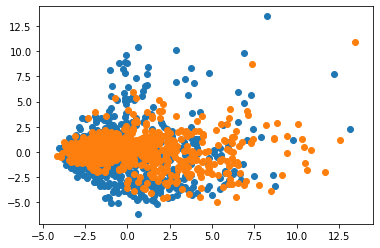

In [147]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_dr = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X_feat))

fig, ax = plt.subplots()
ax.scatter(X_dr[y == 0, 0], X_dr[y == 0, 1])
ax.scatter(X_dr[y == 1, 0], X_dr[y == 1, 1])

In [133]:
lr.coef_

array([[-0.58275446,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.01423688, -0.05576244, -0.20111076,  0.        ,
        -0.05162232, -0.15981633,  0.        , -0.03227111, -0.24534055,
         0.        ,  0.        ,  0.        ,  0.17473974,  0.34975533,
         0.10231176,  0.25232073,  0.14028687,  0.37894233,  0.06654205,
         0.03099687,  0.        ,  0.        ,  0.        ,  0.        ]])

In [131]:
np.argwhere(lr.coef_.squeeze()).squeeze()

array([ 0,  6,  7,  8, 10, 11, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25])

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Xtr, Xte, ytr, yte = train_test_split(X_feat, y, test_size=0.2, random_state=101)

scaler = StandardScaler().fit(Xtr)
lr = LogisticRegression(C=1e0, penalty='l2', max_iter=1000).fit(skb.transform(scaler.transform(Xtr)), ytr)
print(lr.score(skb.transform(scaler.transform(Xtr)), ytr))
print(lr.score(skb.transform(scaler.transform(Xte)), yte))

knn = KNeighborsClassifier(n_neighbors=5).fit(scaler.transform(Xtr), ytr)
print(knn.score(scaler.transform(Xte), yte))

svm = SVC(C=0.5, class_weight={0 : 1, 1 : 1.5}).fit(scaler.transform(Xtr), ytr)
print(svm.score(scaler.transform(Xtr), ytr))
print(svm.score(scaler.transform(Xte), yte))

0.72078501338091
0.7651245551601423
0.7900355871886121
0.8180196253345228
0.7900355871886121


In [160]:
dump(scaler, 'model/scaler.joblib')
dump(svm, 'model/svm.joblib')

['model/svm.joblib']

In [172]:
from sklearn.neighbors import KNeighborsClassifier

rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=42)
scores_tr = np.empty(20)
scores_te = np.empty(20)
for i, (tr_idx, te_idx) in enumerate(rkf.split(X_feat)):
    Xtr, Xte = X_feat[tr_idx], X_feat[te_idx]
    ytr, yte = y[tr_idx], y[te_idx]
    
#     scaler = StandardScaler().fit(Xtr)
#     model = KNeighborsClassifier(n_neighbors=5).fit(scaler.transform(Xtr), ytr)
#     model = LogisticRegression(C=10.0, penalty='l2').fit(scaler.transform(Xtr), ytr)
    model = SVC(C=10.0, class_weight={0 : 1, 1 : 1.5}).fit(scaler.transform(Xtr), ytr)
    scores_tr[i] = model.score(scaler.transform(Xtr), ytr)
    scores_te[i] = model.score(scaler.transform(Xte), yte)
print('{:.4f}, {:.4f}'.format(np.mean(scores_tr), np.std(scores_tr)))
print('{:.4f}, {:.4f}'.format(np.mean(scores_te), np.std(scores_te)))

0.9431, 0.0047
0.7810, 0.0211


In [13]:
from joblib import dump, load

scaler = load('model/scaler.joblib')
svm = load('model/svm.joblib')

<IPython.core.display.Javascript object>


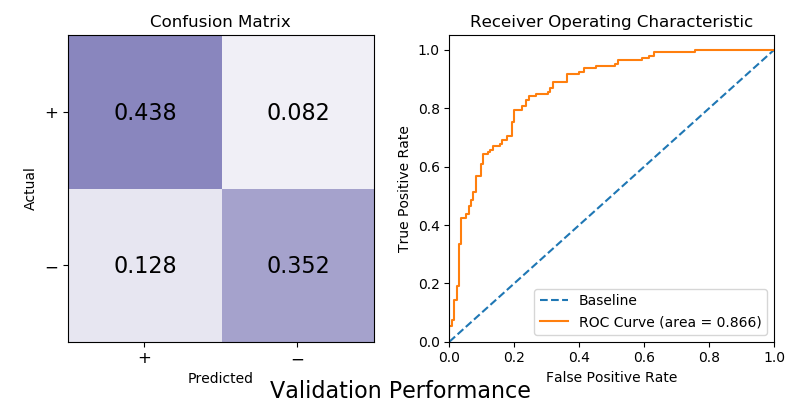

In [159]:
from sklearn.metrics import roc_curve, roc_auc_score

yte_pre = svm.predict(scaler.transform(Xte))

conf_mat_te = np.empty((2,2))
conf_mat_te[1, 1] = np.sum((yte_pre == 1) & (yte == 1))
conf_mat_te[0, 1] = np.sum((yte_pre == 1) & (yte == 0))
conf_mat_te[1, 0] = np.sum((yte_pre == 0) & (yte == 1))
conf_mat_te[0, 0] = np.sum((yte_pre == 0) & (yte == 0))
conf_mat_te /= len(yte)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
im = axes[0].imshow(conf_mat_te, vmin=0.0, vmax=0.75, cmap='Purples')
for i in range(2):
    for j in range(2):
        axes[0].text(j + 0.2, i - 0.05, '{:.3f}'.format(conf_mat_te[i, j]), fontsize=16)
axes[0].set_xlim([1.5, -0.5])
axes[0].set_ylim([-0.5, 1.5])
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels([r'$-$', r'$+$'], fontsize=12)
axes[0].set_yticklabels([r'$-$', r'$+$'], fontsize=12)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(yte, svm.decision_function(scaler.transform(Xte)), pos_label=1)
auc = roc_auc_score(yte, svm.decision_function(scaler.transform(Xte)))
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Baseline')
axes[1].plot(fpr, tpr, label='ROC Curve (area = {:.3f})'.format(auc))
axes[1].set_xlim([0, 1.0])
axes[1].set_ylim([0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic')
axes[1].legend()
fig.suptitle('Validation Performance', y=0.05, fontsize=16)
fig.tight_layout()
